In [1]:
import cudf
import lightgbm as lgb
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [2]:
%%time 
transactions = cudf.read_csv('storage/transactions_train.csv')
articles = cudf.read_csv('storage/articles.csv')
customers = cudf.read_csv('storage/customers.csv')

customers['FN'].fillna(0.,inplace=True)
customers['Active'].fillna(0.,inplace=True)
customers['club_member_status'].fillna('None',inplace=True)
customers['age'] = customers['age'] / 10
customers['age'] = customers['age'].astype(int)
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().fillna('none')

transactions['t_dat'] = cudf.to_datetime(transactions['t_dat'])

CPU times: user 1.17 s, sys: 1.78 s, total: 2.95 s
Wall time: 5.82 s


In [60]:
def past_purchase_feature(df,transactions):
    transactions['count'] = 1
    
    time_elapsed_last_purchase = transactions['t_dat'].max()-transactions[['customer_id','article_id','t_dat']].groupby(['customer_id','article_id'])['t_dat'].max()
    time_elapsed_last_purchase = time_elapsed_last_purchase.dt.days
    df = df.merge(time_elapsed_last_purchase,on=['article_id','customer_id'],how='left')
    df = df.rename(columns={'t_dat':'time_elapsed_last_purchase'})
    df['time_elapsed_last_purchase'].fillna(1e6,inplace=True)
    
    time_elapsed_first_release = transactions[['customer_id','article_id','t_dat']].groupby(['customer_id','article_id'])['t_dat'].min()-cudf.to_datetime('2018-09-01')
    time_elapsed_first_release = time_elapsed_first_release.dt.days
    df = df.merge(time_elapsed_first_release,on=['article_id','customer_id'],how='left')
    df = df.rename(columns={'t_dat':'time_elapsed_first_release'})
    df['time_elapsed_first_release'].fillna(1e6,inplace=True)
    
    past_purchase_prob = transactions[['customer_id','article_id','count']].groupby(['customer_id','article_id'])['count'].count().reset_index()
    norm = transactions[['customer_id','article_id']].groupby('customer_id').count().reset_index().rename(columns={'article_id':'norm'})
    past_purchase_prob = past_purchase_prob.merge(norm,on='customer_id')
    past_purchase_prob['count'] = past_purchase_prob['count'] / past_purchase_prob['norm']
    past_purchase_prob.drop(columns=['norm'],inplace=True)
    df = df.merge(past_purchase_prob,on=['article_id','customer_id'],how='left')
    df = df.rename(columns={'count':'past_purchase_prob'})
    df['past_purchase_prob'].fillna(0.,inplace=True)
    
    total_purchase = transactions[['article_id','count']].groupby('article_id')['count'].count().reset_index().rename(columns={'count':'total_purchase'})
    norm = transactions['count'].sum()
    total_purchase['total_purchase'] = total_purchase['total_purchase'] / norm
    df = df.merge(total_purchase,on='article_id',how='left')
    df['total_purchase'].fillna(0.,inplace=True)
    
    number_of_purchase = transactions[['customer_id','count']].groupby('customer_id')['count'].count().reset_index().rename(columns={'count':'number_of_purchase'})
    df = df.merge(number_of_purchase,on='customer_id',how='left')
    df['number_of_purchase'].fillna(0.,inplace=True)
    
    repeated_purchase = transactions[['customer_id','article_id','count']].groupby(['customer_id','article_id'])['count'].count().reset_index().rename(columns={'count':'repeated_purchase'})
    df = df.merge(repeated_purchase,on=['customer_id','article_id'],how='left')
    
    min_dat_purchase = transactions.groupby(['article_id'])['t_dat'].min()
    max_dat_purchase = transactions.groupby(['article_id'])['t_dat'].max()
    sale_duration = (max_dat_purchase - min_dat_purchase).to_frame().reset_index().rename(columns={'t_dat':'duration'})
    sale_duration['duration'] = sale_duration['duration'].dt.days
    sale_count = transactions.groupby(['article_id'])['t_dat'].count().to_frame().reset_index().rename(columns={'t_dat':'count'})
    sale_rate = sale_duration.merge(sale_count,on='article_id')
    sale_rate = sale_rate.loc[sale_rate['duration']!=0]
    sale_rate['sale_rate'] = sale_rate['count'] / sale_rate['duration']
    df = df.merge(sale_rate[['article_id','sale_rate']],on='article_id',how='left')

    return df
    
def article_feature_prob_vector(df,transactions,articles,article_features,postfix='_prob',customer_group_name='customer_id'):
    transactions['count'] = 1
    if customer_group_name != 'customer_id':
        df = df.merge(customers[['customer_id',customer_group_name]],on='customer_id',how='left')
        transactions = transactions.merge(customers[['customer_id',customer_group_name]],on='customer_id',how='left')
    for article_feature in article_features:
        transactions = transactions.merge(articles[['article_id',article_feature]],on='article_id',how='left')
        norm = transactions.groupby([customer_group_name])['count'].count().reset_index()
        norm.rename(columns={'count':'norm'},inplace=True)
        count = transactions.groupby([customer_group_name,article_feature])['count'].count().reset_index()
        count = count.merge(norm,on=customer_group_name)
        count['count'] = count['count'] / count['norm']
        count = count.rename(columns={'count':article_feature+postfix})
        count = count[[customer_group_name,article_feature,article_feature+postfix]]
        del(norm)
        df = df.merge(articles[['article_id',article_feature]],on='article_id',how='left')
        df = df.merge(count,on=[customer_group_name,article_feature],how='left')
    return df

def customer_feature_prob_vector(df,transactions,customers,customer_features,postfix='_prob'):
    transactions['count'] = 1
    for customer_feature in customer_features:
        transactions = transactions.merge(customers[['customer_id',customer_feature]],on='customer_id',how='left')
        norm = transactions.groupby(['article_id'])['count'].count().reset_index()
        norm.rename(columns={'count':'norm'},inplace=True)
        count = transactions.groupby(['article_id',customer_feature])['count'].count().reset_index()
        count = count.merge(norm,on='article_id')
        count['count'] = count['count'] / count['norm']
        count = count.rename(columns={'count':customer_feature+postfix})
        count = count[['article_id',customer_feature,customer_feature+postfix]]
        del(norm)
        df = df.merge(customers[['customer_id',customer_feature]],on='customer_id',how='left')
        df = df.merge(count,on=['article_id',customer_feature],how='left')
    return df

def construct_feature_df(
        df,transactions,
        article_features,
        articles,
        customer_features,
        customers,
        general_features=['article_id','customer_id'],
    ):
    df = article_feature_prob_vector(df,transactions,articles,article_features)
    df = customer_feature_prob_vector(df,transactions,customers,customer_features)
    df = past_purchase_feature(df,transactions)
    df = df[
            general_features+[f for f in df.columns if '_prob' in f] + 
            ['total_purchase','time_elapsed_last_purchase','past_purchase_prob','number_of_purchase','time_elapsed_first_release','repeated_purchase']
        ]
    return df

def construct_candidate_dict(transactions_3w):
    purchase_dict_3w = {}
    for i,x in enumerate(zip(transactions_3w['customer_id'], transactions_3w['article_id'])):
        cust_id, art_id = x
        if cust_id not in purchase_dict_3w:
            purchase_dict_3w[cust_id] = {}
        if art_id not in purchase_dict_3w[cust_id]:
            purchase_dict_3w[cust_id][art_id] = 0
        purchase_dict_3w[cust_id][art_id] += 1
    return purchase_dict_3w

def construct_candidate_df(
        test_df,transactions,
        nweek=8,
        n_popular_item=90,
        n_total_item=None,
    ):
    
    recent_transactions = {}
    purchase_dict = {}
    for i in range(1,nweek+1):
        recent_transactions[i] = transactions[(transactions.t_dat>transactions.t_dat.max()-i*pd.Timedelta(7,unit='day'))&(transactions.t_dat<=transactions.t_dat.max()-(i-1)*pd.Timedelta(7,unit='day'))].to_pandas()
        purchase_dict[i] = construct_candidate_dict(recent_transactions[i])
    
    if 1 in recent_transactions:
        most_popular_items_1w_all = list((recent_transactions[1]['article_id'].value_counts()).index)[:n_popular_item]
    else:
        most_popular_items_1w_all = list(transactions['article_id'].value_counts().index.to_arrow().to_pylist())[:n_popular_item]
    
    pred_df = pd.DataFrame()
    pred_df['customer_id'] = test_df['customer_id'].unique()
    
    prediction_list = []
    
    for i, cust_id in enumerate(pred_df['customer_id']):
        s = []
        total_purchase_dict = {}
        
        for i,purchase_dict_week in purchase_dict.items():
            if cust_id in purchase_dict_week:
                l = sorted((purchase_dict_week[cust_id]).items(), key=lambda x: x[1], reverse=True)
                l = [y[0] for y in l]
                for aid in l:
                    if aid not in total_purchase_dict:
                        total_purchase_dict[aid] = 1
                    else:
                        total_purchase_dict[aid] += 1

        for aid in most_popular_items_1w_all[:n_popular_item]:
            if aid not in total_purchase_dict:
                total_purchase_dict[aid] = 1
            else:
                total_purchase_dict[aid] += 1

        if n_total_item is not None:
            total_purchase_dict = {k: v for k, v in sorted(total_purchase_dict.items(), key=lambda item: item[1], reverse=True)}
            s = list(total_purchase_dict.keys())[:n_total_item]
        else:
            s = list(total_purchase_dict.keys())
        
        prediction_list.append(s)
        
    pred_df['article_id'] = prediction_list
    
    return pred_df

def construct_test_df(test_df,transactions,article_features,articles,customer_features,customers,how='outer',n_popular_item=90):
    test_df = construct_candidate_df(test_df,transactions,n_popular_item=n_popular_item).explode(['article_id']).reset_index(drop=True)
    test_df = cudf.from_pandas(test_df)
    test_df = construct_feature_df(test_df,transactions,article_features,articles,customer_features,customers,general_features=['article_id','customer_id'])
    test_df = test_df.fillna(0.)
    test_df['article_id'] = test_df['article_id'].astype(int)
    test_df = test_df.sort_values(['customer_id','article_id']).reset_index(drop=True)
    return test_df

def construct_recent_purchase_df(
        test_df,transactions,
        nweek=3,
    ):
    
    recent_transactions = {}
    purchase_dict = {}
    for i in range(1,nweek+1):
        recent_transactions[i] = transactions[(transactions.t_dat>transactions.t_dat.max()-i*pd.Timedelta(7,unit='day'))&(transactions.t_dat<=transactions.t_dat.max()-(i-1)*pd.Timedelta(7,unit='day'))]
        purchase_dict[i] = construct_candidate_dict(recent_transactions[i])

    pred_df = test_df[['customer_id']]
    article_id_list,recent_purchase_score_list = [],[]
    
    for i, cust_id in enumerate(
        test_df['customer_id'].values.reshape((-1,))
    ):
        s = []
        total_purchase_dict = {}
        
        for i,purchase_dict_week in purchase_dict.items():
            if cust_id in purchase_dict_week:
                l = sorted((purchase_dict_week[cust_id]).items(), key=lambda x: x[1], reverse=True)
                l = [y[0] for y in l][:12]
                for aid in l:
                    if aid not in total_purchase_dict:
                        total_purchase_dict[aid] = 1
                    else:
                        total_purchase_dict[aid] += 1

        total_purchase_dict = {k: v for k, v in sorted(total_purchase_dict.items(), key=lambda item: item[1], reverse=True)}
        article_ids = list(total_purchase_dict.keys())[:12]
        recent_purchase_scores = list(total_purchase_dict.values())[:12]
        
        article_id_list.append(article_ids)
        recent_purchase_score_list.append(recent_purchase_scores)
        
    pred_df['recent_purchase_article_id'] = article_id_list
    pred_df['recent_purchase_score'] = recent_purchase_score_list
    
    return pred_df

def construct_time_period_purchase_df(
        test_df,recent_transactions,
        feature_name,
    ):
    
    purchase_dict = construct_candidate_dict(recent_transactions)

    pred_df = test_df[['customer_id']]
    article_id_list,score_list = [],[]
    
    for i, cust_id in enumerate(
        test_df['customer_id'].values.reshape((-1,))
    ):
        s = []
        total_purchase_dict = {}

        if cust_id in purchase_dict:
            l = sorted((purchase_dict[cust_id]).items(), key=lambda x: x[1], reverse=True)
            l = [y[0] for y in l][:12]
            for aid in l:
                if aid not in total_purchase_dict:
                    total_purchase_dict[aid] = 1
                else:
                    total_purchase_dict[aid] += 1

        total_purchase_dict = {k: v for k, v in sorted(total_purchase_dict.items(), key=lambda item: item[1], reverse=True)}
        article_ids = list(total_purchase_dict.keys())[:12]
        scores = list(total_purchase_dict.values())[:12]
        
        article_id_list.append(article_ids)
        score_list.append(scores)
        
    pred_df[feature_name+'_article_id'] = article_id_list
    pred_df[feature_name+'_score'] = score_list
    
    return pred_df

def construct_popular_purchase_df(
        test_df,transactions,
        feature_name='popular_purchase',
    ):
        
    most_popular_items = list((transactions['article_id'].value_counts()).index)[:12] 
    most_popular_scores = list((transactions['article_id'].value_counts()))[:12]

    pred_df = test_df[['customer_id']]
        
    pred_df[feature_name+'_article_id'] = [most_popular_items]*len(pred_df)
    pred_df[feature_name+'_score'] = [most_popular_scores]*len(pred_df)
    
    return pred_df

def construct_gt_df(test_transactions):
    gt_df = test_transactions.to_pandas().groupby('customer_id')['article_id'].agg(lambda x: x.tolist()).reset_index()
    gt_df.columns = ['customer_id','ground_truth']
    return gt_df

def make_prediction(model,test_df,features,label,k=100,group_name='customer_id'):
    test_x = test_df[features]
    test_pred = model.predict(test_x)
    test_x[group_name] = test_df[group_name]
    test_x['past_purchase_article_id'] = test_df['article_id']
    test_x['past_purchase_score'] = test_pred
    pred_df = test_x.groupby('customer_id') \
                .apply(lambda x: x.sort_values('past_purchase_score',ascending=False)['past_purchase_article_id'].tolist()) \
                .reset_index()
    pred_df.columns = ['customer_id','past_purchase_article_id']
    past_purchase_score = test_x.groupby('customer_id') \
            .apply(lambda x: x.sort_values('past_purchase_score',ascending=False)['past_purchase_score'].tolist()).reset_index()
    past_purchase_score.columns = ['customer_id','past_purchase_score']
    pred_df = pred_df.merge(past_purchase_score,on='customer_id')
    return pred_df[['customer_id','past_purchase_article_id','past_purchase_score']]
 

In [61]:
trn_start_time = '2020-09-07'
trn_end_time = '2020-09-15'
test_start_time = '2020-09-15'
test_end_time = '2020-09-22'

trn_start_time = cudf.to_datetime(trn_start_time)
trn_end_time = cudf.to_datetime(trn_end_time)
test_start_time = cudf.to_datetime(test_start_time)
test_end_time = cudf.to_datetime(test_end_time)

past_transactions = transactions[(transactions.t_dat > cudf.to_datetime('2020-01-01')) & (transactions.t_dat <= trn_end_time)]
trn_transactions = transactions[(transactions.t_dat > trn_start_time) & (transactions.t_dat <= trn_end_time)]
test_transactions = transactions[(transactions.t_dat > test_start_time) & (transactions.t_dat <= test_end_time)]

trn_gt_df = construct_gt_df(trn_transactions)
test_gt_df = construct_gt_df(test_transactions)

In [62]:
def construct_rerank_df(
    customer_df,past_transactions,
    articles,customers,
    past_purchase_model_path,
    label='label',
    gt_df=None,
    verbose=True,
    article_features=[
        'product_type_name','product_group_name',
        'graphical_appearance_name','colour_group_name',
        'perceived_colour_value_name','perceived_colour_master_name',
        'department_name', 'index_name',
        'index_group_name','section_name',
        'garment_group_name',
    ],
    customer_features=[
        'FN','Active','club_member_status','age','fashion_news_frequency',
    ],
):
    past_purchase_df = construct_test_df(
        customer_df,past_transactions,
        article_features,articles,
        customer_features,customers,
        how='outer',n_popular_item=90
    )    
    bst = lgb.Booster(model_file=past_purchase_model_path)
    features = [c for c in past_purchase_df.columns if c not in ['article_id','customer_id','label','index','group_size']]
    past_purchase_df = make_prediction(bst,past_purchase_df.to_pandas(),features,label)
    rerank_df = past_purchase_df.explode(['past_purchase_article_id','past_purchase_score']).rename(columns={'past_purchase_article_id':'article_id'})

    recent_purchase_df = construct_recent_purchase_df(
       customer_df,past_transactions.to_pandas(),
    )
    recent_purchase_df = recent_purchase_df.explode(['recent_purchase_article_id','recent_purchase_score']).rename(columns={'recent_purchase_article_id':'article_id'})
    rerank_df = rerank_df.merge(recent_purchase_df,on=['customer_id','article_id'],how='outer')
    
    for iweek in range(1,4):
        feature_name = 'popular_purchase_{:d}w'.format(iweek)
        recent_transactions = past_transactions[
            (past_transactions.t_dat>past_transactions.t_dat.max()-iweek*pd.Timedelta(7,unit='day'))&
            (past_transactions.t_dat<=past_transactions.t_dat.max()-(iweek-1)*pd.Timedelta(7,unit='day'))
        ]
        popular_purchase_df = construct_popular_purchase_df(
            customer_df,recent_transactions.to_pandas(),feature_name,
        )
        popular_purchase_df = popular_purchase_df.explode([feature_name+'_article_id',feature_name+'_score']).rename(columns={feature_name+'_article_id':'article_id'})
        rerank_df = rerank_df.merge(popular_purchase_df,on=['customer_id','article_id'],how='outer')
    
    if gt_df is not None:
        tmp_gt_df = gt_df.copy()
        tmp_gt_df['label'] = 1
        tmp_gt_df = tmp_gt_df.rename(columns={'ground_truth':'article_id'})
        rerank_df = rerank_df.merge(tmp_gt_df[['customer_id','article_id','label']].explode('article_id'),on=['customer_id','article_id'],how='outer')
    
    rerank_df.fillna(0.,inplace=True)
    
    return rerank_df

def evaluate_score(pred_df,gt_df,k=12,verbose=True,group_name='customer_id'):
    from metric import mapk
    eval_df = gt_df.merge(pred_df,on=group_name,how='left')
    score = mapk(eval_df['ground_truth'].tolist(),eval_df['prediction'].tolist())
    if verbose: print('map@'+str(k),score)
    return score

def feval(preds,eval_dataset,k=12):
    pred_df = pd.DataFrame()
    pred_df['customer_id'] = test_df['customer_id']
    pred_df['article_id'] = test_df['article_id']
    pred_df['prediction'] = preds
    pred_df = pred_df.groupby('customer_id') \
                    .apply(lambda x: x.sort_values('prediction',ascending=False)['article_id'].tolist()[:k]) \
                    .reset_index()
    pred_df.columns = ['customer_id','prediction']
    score = evaluate_score(pred_df,test_gt_df,group_name='customer_id',verbose=False)
    return 'MAP@'+str(k), score, True
    

In [63]:
%%time
trn_df = construct_rerank_df(
    trn_gt_df[['customer_id']],past_transactions,
    articles,customers,
    'storage/output/220325_lightgbm_training/220325_dataset_2020-06-01_2020-08-01_2020-09-15_2020-09-22_score:0.0230037_objective:lambdarank_metric:map@12_boosting:dart_seed:0_learning_rate:0.03_num_threads:8_num_iterations:15_early_stopping_round:None.bin',
    label='label',
    gt_df=trn_gt_df,
)

/scratch/local/22601025/ipykernel_17601/2814705841.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[group_name] = test_df[group_name]


CPU times: user 1min 15s, sys: 15.1 s, total: 1min 30s
Wall time: 1min 24s


In [64]:
%%time
test_df = construct_rerank_df(
    test_gt_df[['customer_id']],past_transactions,
    articles,customers,
    'storage/output/220325_lightgbm_training/220325_dataset_2020-06-01_2020-08-01_2020-09-15_2020-09-22_score:0.0230037_objective:lambdarank_metric:map@12_boosting:dart_seed:0_learning_rate:0.03_num_threads:8_num_iterations:15_early_stopping_round:None.bin',
    label='label',
)

/scratch/local/22601025/ipykernel_17601/2814705841.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[group_name] = test_df[group_name]


CPU times: user 1min 5s, sys: 12.5 s, total: 1min 17s
Wall time: 1min 13s


****Reranking with Logistic Regression****

In [69]:
features = [c for c in trn_df.columns if 'score' in c]
target = 'label'
print(' '.join(features))

past_purchase_score recent_purchase_score popular_purchase_1w_score


In [70]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1).fit(trn_df[features],trn_df[target])
print(clf.coef_, clf.intercept_)

[[ 3.90500613e+01  3.11595989e+00 -4.95024003e-04]] [-6.6176302]
CPU times: user 39.1 s, sys: 31.1 s, total: 1min 10s
Wall time: 39 s


In [71]:
%%time
preds = clf.predict_proba(test_df[features])
_,score,_ = feval(preds[:,1],None,k=12)
print(score)

0.022238216132188435
CPU times: user 13.1 s, sys: 1.07 s, total: 14.2 s
Wall time: 13.6 s


In [68]:
trn_df

,customer_id,article_id,past_purchase_score,recent_purchase_score,popular_purchase_1w_score,popular_purchase_2w_score,popular_purchase_3w_score,label
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,794321007.0,0.232283,1.0,0.0,0.0,0.0,1.0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,783346001.0,0.035045,0.0,0.0,0.0,0.0,0.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,751471001.0,0.029059,0.0,607.0,724.0,846.0,0.0
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,706016001.0,0.023665,0.0,0.0,683.0,701.0,0.0
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,448509014.0,0.020612,0.0,609.0,529.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8237321,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,915526002.0,0.000000,0.0,0.0,0.0,622.0,0.0
8237322,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,862970001.0,0.000000,0.0,0.0,0.0,539.0,0.0
8237323,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,933706001.0,0.000000,0.0,0.0,0.0,920.0,0.0
8237324,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,915526002.0,0.000000,0.0,0.0,0.0,622.0,0.0


****Reranking with LightGBM****

In [152]:
def x_y_group(data,features,target,only_x=False,verbose=False):
    data = data.sort_values('customer_id').reset_index()
    group = data.groupby('customer_id').size().to_frame('size')['size']
    return data[features],data[target],group

In [182]:
trn_x,trn_y,trn_grp = x_y_group(trn_df,features,target)
trn_dataset = lgb.Dataset(trn_x,label=trn_y,group=trn_grp)

test_dataset = lgb.Dataset(test_df[features])

In [167]:
%%time
param = dict(
    objective='lambdarank',
    metric='map@12',
    boosting='dart',
    num_round = 1,
    seed=0,
    learning_rate=0.1,
    num_threads=8,
)
bst = lgb.train(
    param,
    trn_dataset,
    feval=feval,
    valid_sets=[test_dataset],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 7835273, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's MAP@12: 0.0206276
CPU times: user 15.8 s, sys: 339 ms, total: 16.2 s
Wall time: 14.6 s


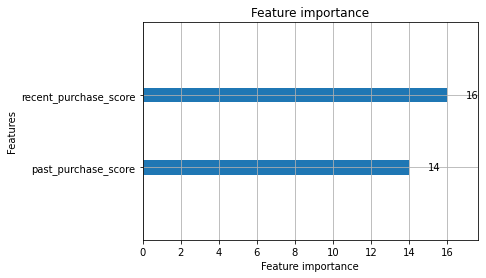

In [162]:
fig = lgb.plot_importance(bst)

In [163]:
bst.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S4,0-S1,None,past_purchase_score,6.876310e+06,7.372254e-02,<=,left,None,-3.252880,0.000000,7835273
1,0,2,0-S4,0-L0,0-S5,0-S0,past_purchase_score,1.562120e+04,5.470470e-02,<=,left,None,-3.355190,269290.000000,7514130
2,0,3,0-L0,None,None,0-S4,None,NaN,NaN,None,None,None,-3.356748,268161.147576,7482618
3,0,3,0-S5,0-L5,0-S16,0-S4,recent_purchase_score,3.044600e+03,1.000000e-35,<=,left,None,-2.984050,1129.320000,31512
4,0,4,0-L5,None,None,0-S5,None,NaN,NaN,None,None,None,-3.284117,260.218829,7261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,6,0-S18,0-L12,0-S19,0-S11,recent_purchase_score,8.411870e-02,1.500000e+00,<=,left,None,-0.578386,1093.380000,30509
57,0,7,0-L12,None,None,0-S18,None,NaN,NaN,None,None,None,-0.578153,1021.415348,28501
58,0,7,0-S19,0-L19,0-L20,0-S18,recent_purchase_score,5.535580e-02,2.500000e+00,<=,left,None,-0.581690,71.962500,2008
59,0,8,0-L19,None,None,0-S19,None,NaN,NaN,None,None,None,-0.582193,69.668834,1944


In [164]:
trn_df

,customer_id,article_id,past_purchase_score,recent_purchase_score,label
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,794321007,0.232283,1.0,1.0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,783346001,0.035045,0.0,0.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,751471001,0.029059,1.0,0.0
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,706016001,0.023665,0.0,0.0
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,448509014,0.020612,1.0,0.0
...,...,...,...,...,...
7835268,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,923758001,-0.103118,0.0,0.0
7835269,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,884319003,-0.103652,0.0,0.0
7835270,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,929165002,-0.104906,0.0,0.0
7835271,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,865929003,-0.123423,0.0,0.0
